# The objective of this Notebook is to forecast YoY GDP and CPI for the US using an LSTM Neural Network

In [3]:
# Importation of the libraries:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
TODAY = date.today().strftime("%Y%m%d")
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('fivethirtyeight')

# When a timeseries is not available at a monthly frequency, the last value is repeated till a new one is available.

In [4]:
# Reading and Cleaning of the Data:
Data_for_CPI_final = pd.read_csv("Data_for_CPI.csv")
Data_for_GDP_final = pd.read_csv("Data_for_GDP.csv")

Data_for_CPI_final = Data_for_CPI_final[2:]
Data_for_GDP_final = Data_for_GDP_final[2:]

Data_for_CPI_final.rename(columns = {Data_for_CPI_final.columns[0] :"Unnamed: 0" },inplace = True)
Data_for_GDP_final.rename(columns = {Data_for_GDP_final.columns[0] :"Unnamed: 0" },inplace = True)

Data_for_CPI_final.set_index(Data_for_CPI_final.columns[0],inplace =True)
Data_for_GDP_final.set_index(Data_for_GDP_final.columns[0],inplace =True)

Data_for_CPI_final.reset_index(inplace = True)
Data_for_CPI_final["index"] = Data_for_CPI_final["Unnamed: 0"].astype(str)

Data_for_GDP_final.reset_index(inplace = True)
Data_for_GDP_final["index"] = Data_for_GDP_final["Unnamed: 0"].astype(str)

# Time series have duplicates, I remove them :  
for k in range (1,len(Data_for_CPI_final)):
    if Data_for_CPI_final["index"][k][:7] == Data_for_CPI_final["index"][k-1][:7]:
        Data_for_CPI_final.drop(k-1,inplace= True)

for k in range (1,len(Data_for_GDP_final)):
    if Data_for_GDP_final["index"][k][:7] == Data_for_GDP_final["index"][k-1][:7]:
        Data_for_GDP_final.drop(k-1,inplace= True)    

index_list_GDP = Data_for_GDP_final["index"]
index_list_CPI = Data_for_CPI_final["index"]

Data_for_CPI_final.bfill(axis ='rows',inplace = True)
Data_for_GDP_final.bfill(axis ='rows',inplace = True)

Data_for_CPI_final.ffill(axis ='rows',inplace = True)
Data_for_GDP_final.ffill(axis ='rows',inplace = True)

Data_for_CPI_final.set_index("index",inplace=True)
Data_for_GDP_final.set_index("index",inplace=True)

last_date = pd.to_datetime(Data_for_CPI_final.index[-1])
# Index List : 
index_list = pd.to_datetime(Data_for_CPI_final.index)

Data_for_CPI_final.drop(columns = "Unnamed: 0",inplace = True)
Data_for_GDP_final.drop(columns = "Unnamed: 0",inplace = True)

Data_for_CPI_final = Data_for_CPI_final.astype(float)
Data_for_GDP_final = Data_for_GDP_final.astype(float)

In [7]:
Data_for_CPI_final.columns

Index(['CPI XCHG Index', 'CPI XYOY Index', 'CPI INDX Index', 'PCE CORE Index',
       'SPY US Equity', 'CPIQNCCS Index', 'CPI YOY Index', 'PPI YOY Index'],
      dtype='object')

In [ ]:
# About the feature used to train the model:
## As we want to forecast macro economics Data, there is a couple of other macro indicator related to each of these data of interest.
### here is the list of indicator used for the GDP : 
"""
'RSTAXAGM Index' : Retail Sales less food services, auto dealer & build Mat
'CONCUN35 Index' : 
'EMPRNEMP Index' : Employement for the US 
'USURTOT Index' :  Unemployement rate for the US
'IP CHNG Index' : Industrial Production for the US
'NAPMPMI Index' : ISM Manufacturing PMI SA (the view on the economy provided by professionals)
"""
### Here is the list of indicator used for the CPI : 
"""
'CPI XCHG Index' :  US CPI Urban Consumers Less Food & Energy MoM SA
'CPI XYOY Index' : US CPI Urban Consumers Less Food & Energy YoY SA
'CPI INDX Index' : Consumer Price Index for All Urban Consumers
'PCE CORE Index' : US Personal Consumption Expenditure Core Price Index MoM SA
'SPY US Equity' : S&P 500 Daily quotations
'CPIQNCCS Index' : 
'PPI YOY Index' : U.S. Producer Price Index (PPI) YoY
"""

# Now that the data are clean let's pre process them :

In [313]:
# First let's Scale them:  
from sklearn.preprocessing import StandardScaler

scaler_CPI = StandardScaler()
scaler_GDP = StandardScaler()

scaler_CPI.fit(Data_for_CPI_final)
scaler_GDP.fit(Data_for_GDP_final)

Scaled_CPI_frame  = scaler_CPI.transform(Data_for_CPI_final) 
Scaled_GDP_frame  = scaler_GDP.transform(Data_for_GDP_final) 

CPI_to_plot = pd.DataFrame(Scaled_CPI_frame)
GDP_to_plot = pd.DataFrame(Scaled_GDP_frame)

CPI_to_plot.index = index_list
GDP_to_plot.index = index_list

CPI_to_plot.columns = Data_for_CPI_final.columns
GDP_to_plot.columns = Data_for_GDP_final.columns

Text(0.5, 1.0, 'Scaled training data to forecast CPI')

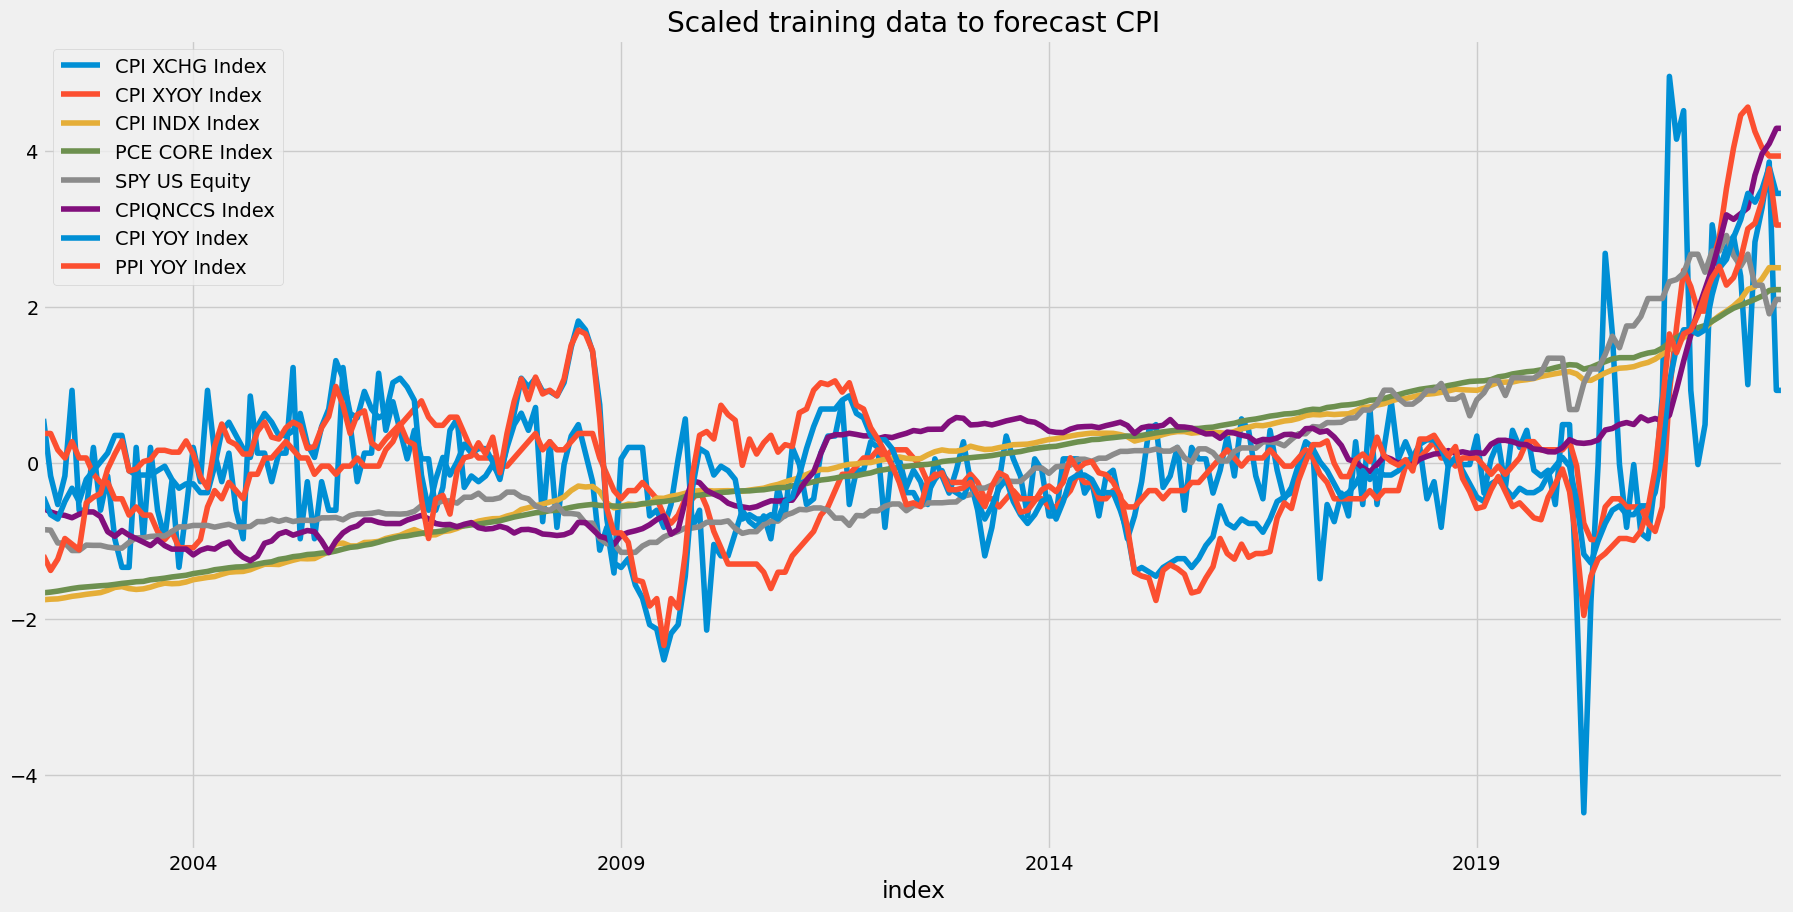

In [314]:
CPI_to_plot.plot(figsize = (20,10))
plt.title("Scaled training data to forecast CPI")

Text(0.5, 1.0, 'Scaled training data to forecast GDP')

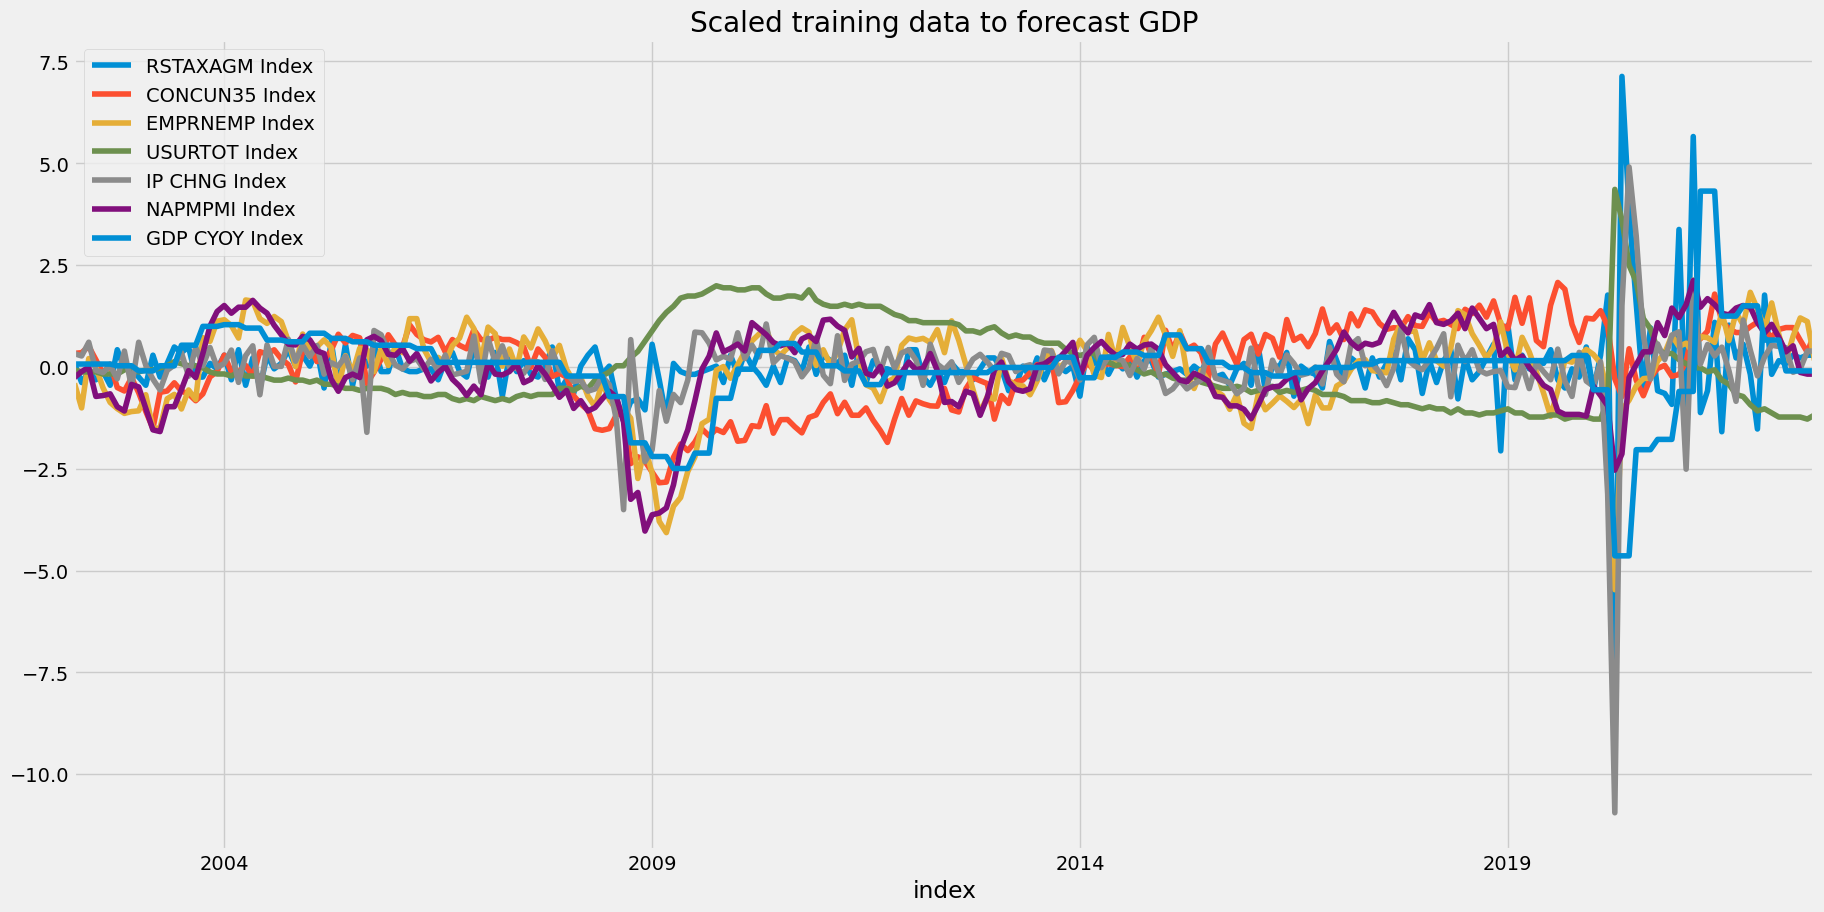

In [315]:
GDP_to_plot.plot(figsize = (20,10))
plt.title("Scaled training data to forecast GDP")

# About the feature used to forecast the Macro Data : 

# Let's make an ACP, the obective is to minimize the amount of feature on wich I train the model

In [348]:
from sklearn.decomposition import PCA
# Lets find the best amount of feature, the approach is based on Explained Variance %: 
n_feature_list = [1,2,3,4,5,6]

explained_ratio_list_CPI = []
explained_ratio_list_GDP = []

# Lets remove the feature to explain: 
CPI_Frame_to_perform_PCA = CPI_to_plot.drop(columns = ["CPI YOY Index"])
GDP_Frame_to_perform_PCA = GDP_to_plot.drop(columns = ["GDP CYOY Index"])

for value in n_feature_list:
    
    mypca = PCA(n_components=value) 
    mypca2 = PCA(n_components=value) 
    
    mypca.fit(CPI_Frame_to_perform_PCA)
    mypca2.fit(GDP_Frame_to_perform_PCA)

    explained_ratio_list_CPI.append(np.sum(mypca.explained_variance_ratio_))
    explained_ratio_list_GDP.append(np.sum(mypca2.explained_variance_ratio_))
    
explained_ratio_list_CPI = pd.DataFrame(explained_ratio_list_CPI)
explained_ratio_list_GDP = pd.DataFrame(explained_ratio_list_GDP)

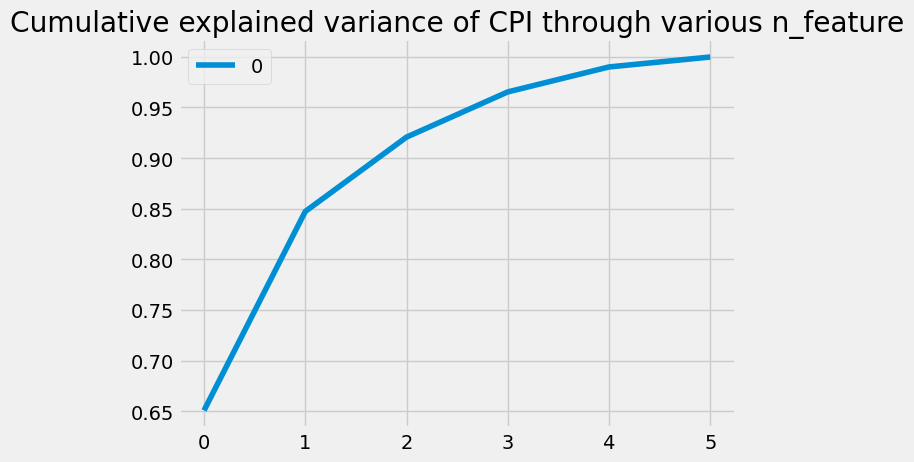

In [351]:
explained_ratio_list_CPI.plot()
plt.title("Cumulative explained variance of CPI through various n_feature")
plt.legend()

## 3 Feature is ok as they explain more than 95% of the whole variance

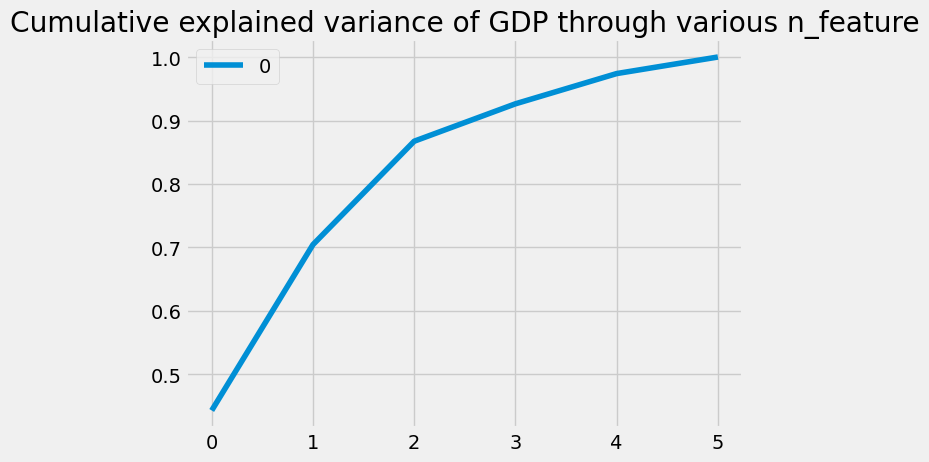

In [353]:
explained_ratio_list_GDP.plot()
plt.title("Cumulative explained variance of GDP through various n_feature")
plt.legend()

## For the GDP I chose to use 4 feature to be aligned with the level of explained variance used for CPI
## Let's now appply the right PCA to our feature dataframes and prepare them for training the model:

In [356]:
# CPI:
mypca_CPI = PCA(n_components=3) 
mypca_CPI.fit(CPI_Frame_to_perform_PCA)
Dataframe_to_forecast_CPI = mypca_CPI.fit_transform(CPI_Frame_to_perform_PCA)
# GDP: 
mypca_GDP = PCA(n_components=4) 
mypca_GDP.fit(GDP_Frame_to_perform_PCA)
Dataframe_to_forecast_GDP = mypca_GDP.fit_transform(GDP_Frame_to_perform_PCA)

Dataframe_to_forecast_GDP = pd.DataFrame(Dataframe_to_forecast_GDP)
Dataframe_to_forecast_GDP.columns = ["1","2","3","4"]

Dataframe_to_forecast_CPI = pd.DataFrame(Dataframe_to_forecast_CPI)
Dataframe_to_forecast_CPI.columns = ["1","2","3"]

from numpy import array
from numpy import hstack

# Explainable Dataframe to forecast US CPI: 
in_seq1 = array(Dataframe_to_forecast_CPI["1"])
in_seq2 = array(Dataframe_to_forecast_CPI["2"])
in_seq3 = array(Dataframe_to_forecast_CPI["3"])
out_seq1 = array(CPI_to_plot["CPI YOY Index"])
# Convert to [rows, columns] structure for the CPI : 
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq1 = out_seq1.reshape((len(out_seq1), 1))

# Explainable Dataframe to forecast US GDP: 
in_seq4 = array(Dataframe_to_forecast_GDP["1"])
in_seq5 = array(Dataframe_to_forecast_GDP["2"])
in_seq6= array(Dataframe_to_forecast_GDP["3"])
in_seq7= array(Dataframe_to_forecast_GDP["4"])
out_seq2 = array(GDP_to_plot["GDP CYOY Index"])

# Convert to [rows, columns] structure for the GDP: 
in_seq4 = in_seq9.reshape((len(in_seq4), 1))
in_seq5 = in_seq10.reshape((len(in_seq5), 1))
in_seq6 = in_seq11.reshape((len(in_seq6), 1))
in_seq7 = in_seq12.reshape((len(in_seq7), 1))
out_seq2 = out_seq2.reshape((len(out_seq2), 1))

# Horizontally stack columns : 
dataset_for_CPI = hstack((in_seq1,in_seq2,in_seq3,out_seq1))
dataset_for_GDP = hstack((in_seq4,in_seq5,in_seq6,in_seq7,out_seq2))

dataset_for_CPI = pd.DataFrame(dataset_for_CPI)
dataset_for_GDP = pd.DataFrame(dataset_for_GDP)

# Let's now define the Neural Network : 
## The model used is a double layers stacked LSTM of size 50 
## Relu as activation function 
## Adam as optmimizer 
## mse as loss function

In [425]:
from sklearn.metrics import mean_squared_error
from keras import Sequential 
from tensorflow.keras import layers

# Split Stacked time_series into Train/Test frames : 
def split_sequences(sequences, n_steps):
    
    X, y = list(), list()
    
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X),array(y)

# This function is used to train the model:
def train_model(n_step,n_feature,dataset_train,n_epoch):
    
    X, y = split_sequences(dataset_train, n_step)
    # Next two rows are important 
    y = y[1:]
    X = X[:-1]

    # Define the model : 
    model = Sequential()
    model.add(layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_step,
                                                                           n_feature)))
    model.add(layers.LSTM(50, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # Model fit :
    model.fit(X, y, epochs=n_epoch, verbose=2)
    
    yhat = np.zeros((len(X),1))

    for i in range (len(X)):
        x_input = []
        for k in range (n_step):
            x_input.append([X[i][k]])
        x_input = array(x_input)
        x_input = x_input.reshape((n_step,1,n_feature))
        x_input = x_input.reshape((1, n_step, n_feature))
        yhat[i] = float(model.predict(x_input, verbose=0))

    return yhat,model

# This function take the trained model a sinput and gives the 5 last values:
def test_model(n_step,n_feature,dataset_test,trained_model):
    
    X, y = split_sequences(dataset_test, n_step)
    # Next two rows are important 
    y = y[1:]
    X = X[:-1]
    
    yhat = np.zeros((len(X),1))

    for i in range (len(X)):
        x_input = []
        for k in range (n_step):
            x_input.append([X[i][k]])
        x_input = array(x_input)
        x_input = x_input.reshape((n_step,1,n_feature))
        x_input = x_input.reshape((1, n_step, n_feature))
        yhat[i] = float(trained_model.predict(x_input, verbose=0))

    return yhat

In [426]:
# Train and test DataFrames: 
n_step = 5 # 5 means that each time the model will have the 5 last values of each feature to forecast the next explained one :
lenght_train = int(0.96*245) # As it is Macro data forecasting, I only want my model to give the last 5 macro values 
# By doing that I keep my model fresh

Train_CPI = dataset_for_CPI[:lenght_train]
Test_CPI = dataset_for_CPI[lenght_train:]

Train_GDP = dataset_for_GDP[:lenght_train]
Test_GDP = dataset_for_GDP[lenght_train:]

In [443]:
Predicted_CPI,model_CPI = Train_model(5,4,array(Train_CPI),100)

liste_CPI = []
liste_CPI.append(array([Predicted_CPI[0][0]]))

for value in Predicted_CPI : 
    liste_CPI.append(value)

resultats_CPI = []
for j in range(n_step-1):
    resultats_CPI.append(CPI_to_plot["CPI YOY Index"][j])
for value in liste_CPI:
    resultats_CPI.append(value[0])
    
Tested_CPI = test_model(5,4,array(Test_CPI),model_CPI)

for j in range(n_step):
    resultats_CPI.append(CPI_to_plot["CPI YOY Index"].iloc[-len(Test_CPI)+j])
    
for value in Tested_CPI:
    resultats_CPI.append(value[0])
    
predicted_liste = pd.DataFrame(predicted_liste)
resultats_CPI = pd.DataFrame(resultats_CPI)

Text(0.5, 1.0, 'Predicted and real YoY US CPI')

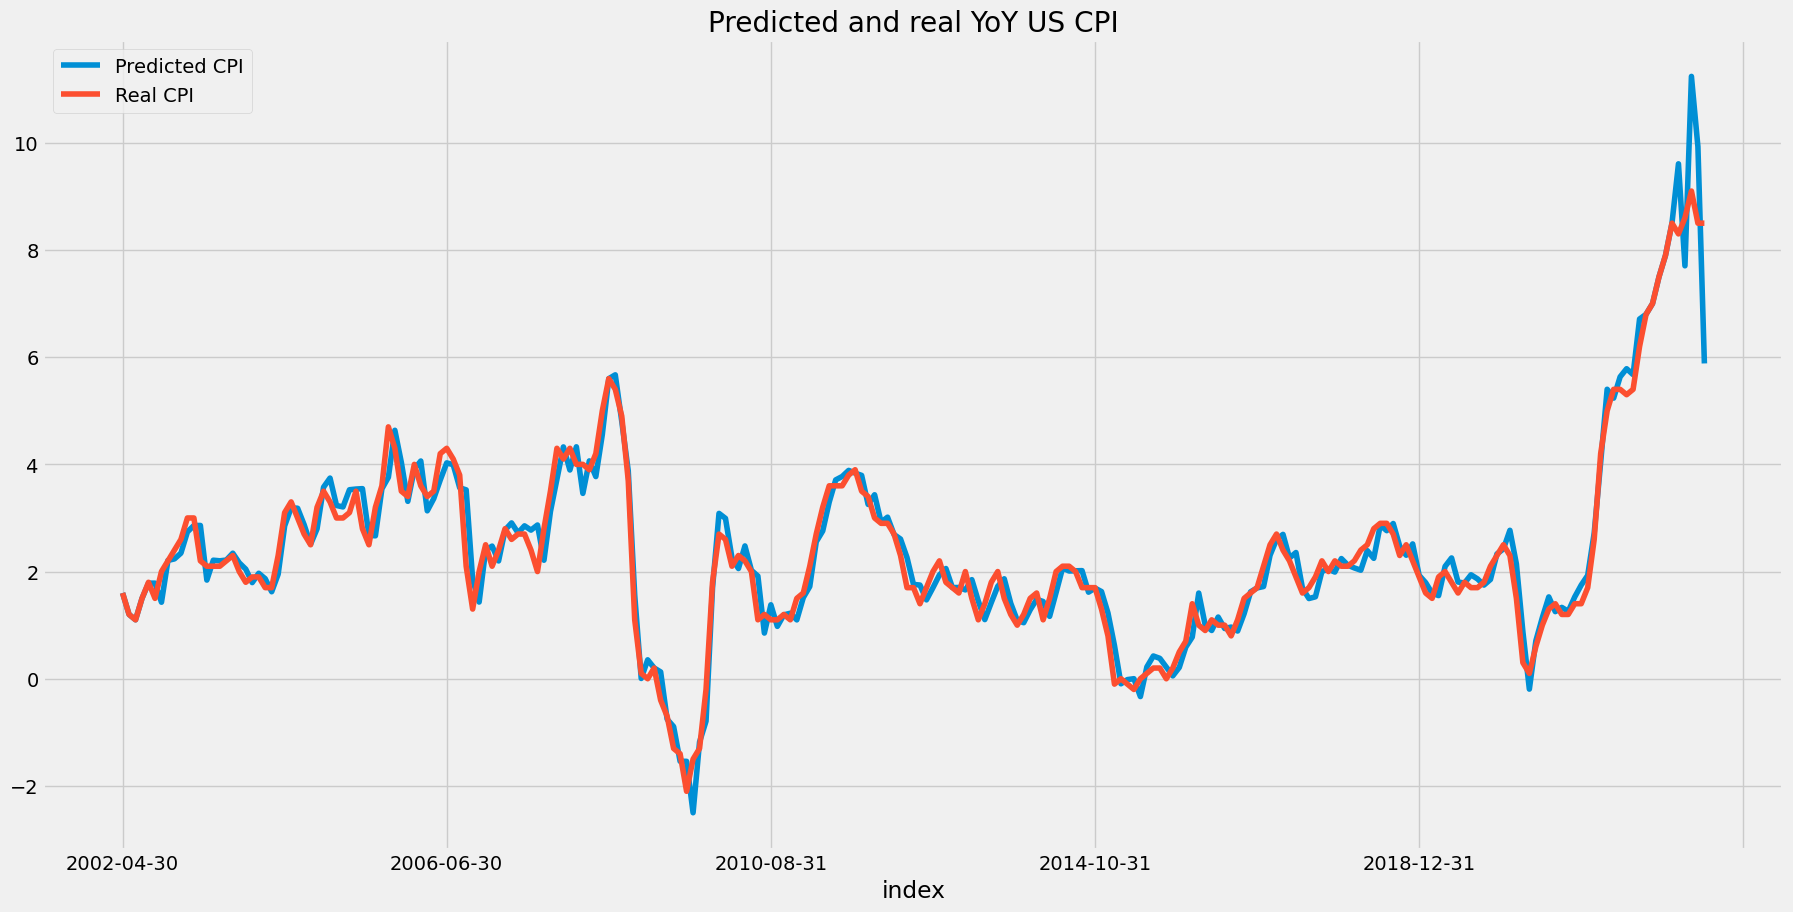

In [444]:
dataset_CPI_to_revere_scale = CPI_to_plot[-len(resultats_CPI):]
dataset_CPI_to_revere_scale["CPI YOY Index"] = resultats_CPI.values

reveresed_CPI_frame_with_Y_pred = scaler_CPI.inverse_transform(dataset_CPI_to_revere_scale)
reveresed_CPI_frame_with_Y_pred = pd.DataFrame(reveresed_CPI_frame_with_Y_pred)
reveresed_CPI_frame_with_Y_pred.index = Data_for_CPI_final.index
reveresed_CPI_frame_with_Y_pred.columns = Data_for_CPI_final.columns

reveresed_CPI_frame_with_Y_pred["CPI YOY Index"].plot(figsize = (20,10),label = "Predicted CPI")
Data_for_CPI_final["CPI YOY Index"].plot(figsize = (20,10),label = "Real CPI")
plt.legend()
plt.title("Predicted and real YoY US CPI")

In [445]:
Y_true_train = Data_for_CPI_final["CPI YOY Index"][:len(Train_CPI)]
Y_pred_train = reveresed_CPI_frame_with_Y_pred["CPI YOY Index"][:len(Train_CPI)]

Y_true_test = Data_for_CPI_final["CPI YOY Index"][len(Train_CPI):]
Y_pred_test= reveresed_CPI_frame_with_Y_pred["CPI YOY Index"][len(Train_CPI):]

In [446]:
MSE_train = mean_squared_error(Y_true_train,Y_pred_train)
MSE_test = mean_squared_error(Y_true_test,Y_pred_test)

In [447]:
MSE_train

0.10400929192753557

In [448]:
MSE_test

1.5970696412247034

In [ ]:
# By comparing MSE_train and MSE_test we see that the model is slightly overfiting
# Is it a problem as we are able to retrain the model on a monthly basis and this for each month ? 
# We can still have good view on the month ahead value of the Data.

In [455]:
Predicted_GDP,model_GDP =  Train_model(5,5,array(Train_GDP),100)
liste_GDP = []
liste_GDP.append(array([Predicted_GDP[0][0]]))

for value in Predicted_GDP : 
    liste_GDP.append(value)
    
resultats_GDP = []
for j in range(n_step-1):
    resultats_GDP.append(GDP_to_plot["GDP CYOY Index"][j])
for value in liste_GDP:
    resultats_GDP.append(value[0])
    
Tested_GDP = test_model(5,5,array(Test_GDP),model_GDP)

for j in range(n_step):
    resultats_GDP.append(GDP_to_plot["GDP CYOY Index"].iloc[-len(Test_GDP)+j])
    
for value in Tested_GDP:
    resultats_GDP.append(value[0])
    
predicted_liste = pd.DataFrame(predicted_liste)
resultats_GDP = pd.DataFrame(resultats_GDP)

Text(0.5, 1.0, 'Predicted and Real YoY US GDP')

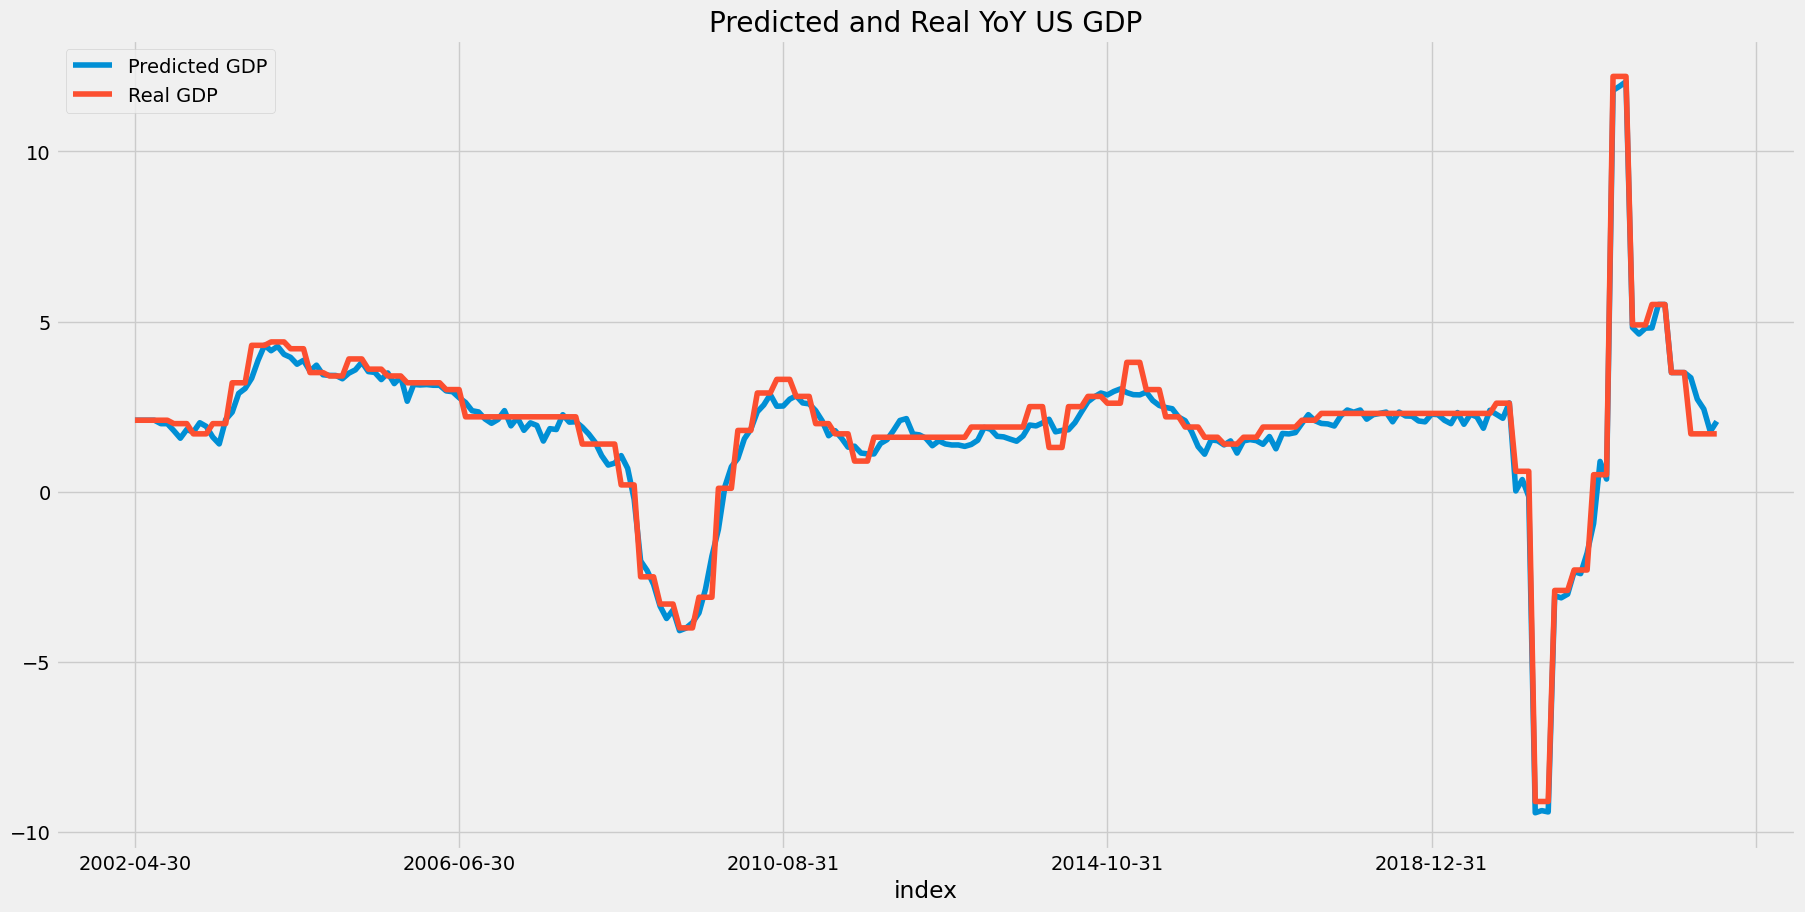

In [456]:
dataset_GDP_to_revere_scale = GDP_to_plot[-len(resultats_GDP):]
dataset_GDP_to_revere_scale["GDP CYOY Index"] = resultats_GDP.values

reveresed_GDP_frame_with_Y_pred = scaler_GDP.inverse_transform(dataset_GDP_to_revere_scale)
reveresed_GDP_frame_with_Y_pred = pd.DataFrame(reveresed_GDP_frame_with_Y_pred)
reveresed_GDP_frame_with_Y_pred.index = Data_for_GDP_final.index
reveresed_GDP_frame_with_Y_pred.columns = Data_for_GDP_final.columns

reveresed_GDP_frame_with_Y_pred["GDP CYOY Index"].plot(figsize = (20,10),label = "Predicted GDP")
Data_for_GDP_final["GDP CYOY Index"].plot(figsize = (20,10),label = "Real GDP")
plt.legend()
plt.title("Predicted and Real YoY US GDP")

In [457]:
Y_true_train = Data_for_GDP_final["GDP CYOY Index"][:len(Train_GDP)]
Y_pred_train = reveresed_GDP_frame_with_Y_pred["GDP CYOY Index"][:len(Train_GDP)]

Y_true_test = Data_for_GDP_final["GDP CYOY Index"][len(Train_GDP):]
Y_pred_test= reveresed_GDP_frame_with_Y_pred["GDP CYOY Index"][len(Train_GDP):]

In [458]:
MSE_train = mean_squared_error(Y_true_train,Y_pred_train)
MSE_test = mean_squared_error(Y_true_test,Y_pred_test)

In [459]:
MSE_train

0.13510045091707668

In [460]:
MSE_test

0.4419005466183921

In [461]:
# By comparing MSE_train and MSE_test we see that the model is also overfitting but the value are closer

# To conclude : 
## Using an LSTM neural network is may not the best answer in order to forecast accurately these macro data.
## As there is clear statistical dependancies between the feature and the data of intestest, I thing we can
## achieve better results by using classical explainable Marchine Learning. 